In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

In [21]:
#Read NO-NO2-NOx Series
dataFrame = pd.read_excel("../data/DataAirTrain.xlsx",index_col= 'time', sheet_name="NO-NO2-NOx")
dataFrame = dataFrame.tail(2000)

In [22]:
dataFrame[['NO','NOx']] = dataFrame[['NO','NOx']].interpolate(method='linear')

In [23]:
#Using linear regression to fill missing data
linearModel = LinearRegression()
dataFrame = dataFrame.copy()
nanMask = dataFrame[['NO2']].isna()
nanMask = nanMask['NO2']

xTrain = dataFrame.loc[~nanMask,['NOx']]
yTrain = dataFrame.loc[~nanMask,['NO2']]

linearModel.fit(xTrain, yTrain)

xTest = dataFrame.loc[nanMask, ['NOx']]
yTest = linearModel.predict(xTest)
dataFrame.loc[nanMask,['NO2']] = yTest

In [24]:
#Fix gap in time index
dataFrame = dataFrame.resample('H').interpolate(method='linear')

In [25]:
from statsmodels.tsa.stattools import adfuller
def stationary(var, desc):
    print(
        f"'{desc}' is stationary: "
        f"{adfuller(var)[0] < adfuller(var)[4]['1%']}.")
stationary(dataFrame.NO, 'NO')
stationary(dataFrame.NO2, 'NO2')
stationary(dataFrame.NOx, 'NOx')

'NO' is stationary: True.
'NO2' is stationary: True.
'NOx' is stationary: True.


In [26]:
trainSet = dataFrame[: -48]
testSet = dataFrame[-48: ]
dataFrameCopy = dataFrame
dataFrame = trainSet

In [27]:
from statsmodels.tsa.api import VAR
model = VAR(dataFrame)

In [28]:
sorted_order = model.select_order(72)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        21.58       21.59   2.365e+09       21.59
1        13.82       13.86   1.007e+06       13.84
2        13.49       13.55   7.201e+05       13.51
3        13.42       13.51   6.737e+05       13.45
4        13.38      13.49*   6.450e+05      13.42*
5        13.37       13.51   6.409e+05       13.42
6        13.36       13.53   6.358e+05       13.42
7        13.36       13.55   6.320e+05       13.43
8        13.35       13.57   6.271e+05       13.43
9        13.34       13.59   6.223e+05       13.43
10       13.34       13.62   6.240e+05       13.44
11       13.33       13.63   6.184e+05       13.44
12       13.33       13.65   6.153e+05       13.45
13       13.33       13.68   6.172e+05       13.46
14       13.34       13.71   6.186e+05       13.47
15       13.34       13.74   6.190e+05       13.48
16       13.34       13.77   6.

In [29]:
lag = sorted_order.aic
results = model.fit(lag)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 11, Mar, 2023
Time:                     23:55:41
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    14.1775
Nobs:                     1951.00    HQIC:                   13.7979
Log likelihood:          -21339.7    FPE:                    788099.
AIC:                      13.5773    Det(Omega_mle):         709012.
--------------------------------------------------------------------
Results for equation NO
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           1.420489         0.923035            1.539           0.124
L1.NO           1.620671         0.057539           28.167           0.000
L1.NO2          0.453590         0.053880            8.418           0.000
L1.NOx      

                             NO         NO2         NOx
time                                                   
2019-09-03 07:00:00    7.107430   15.441467    6.581986
2019-09-03 08:00:00   12.497603   18.554159   12.617561
2019-09-03 09:00:00   17.342792   22.364438   17.764684
2019-09-03 10:00:00   21.653028   25.693829   21.866109
2019-09-03 11:00:00   25.600779   28.270214   25.053133
2019-09-03 12:00:00   30.686740   32.541363   30.154390
2019-09-03 13:00:00   35.275990   35.848577   34.686183
2019-09-03 14:00:00   39.697240   38.477788   38.333417
2019-09-03 15:00:00   42.697181   41.317396   40.984446
2019-09-03 16:00:00   49.268371   45.611056   47.212937
2019-09-03 17:00:00   53.933433   49.107907   52.024086
2019-09-03 18:00:00   57.323248   50.672773   53.476459
2019-09-03 19:00:00   61.670223   53.590792   56.648654
2019-09-03 20:00:00   66.120425   57.227380   60.783795
2019-09-03 21:00:00   70.244131   60.209617   64.235328
2019-09-03 22:00:00   74.415206   63.168232   67

<AxesSubplot:title={'center':'Test Set'}, xlabel='time'>

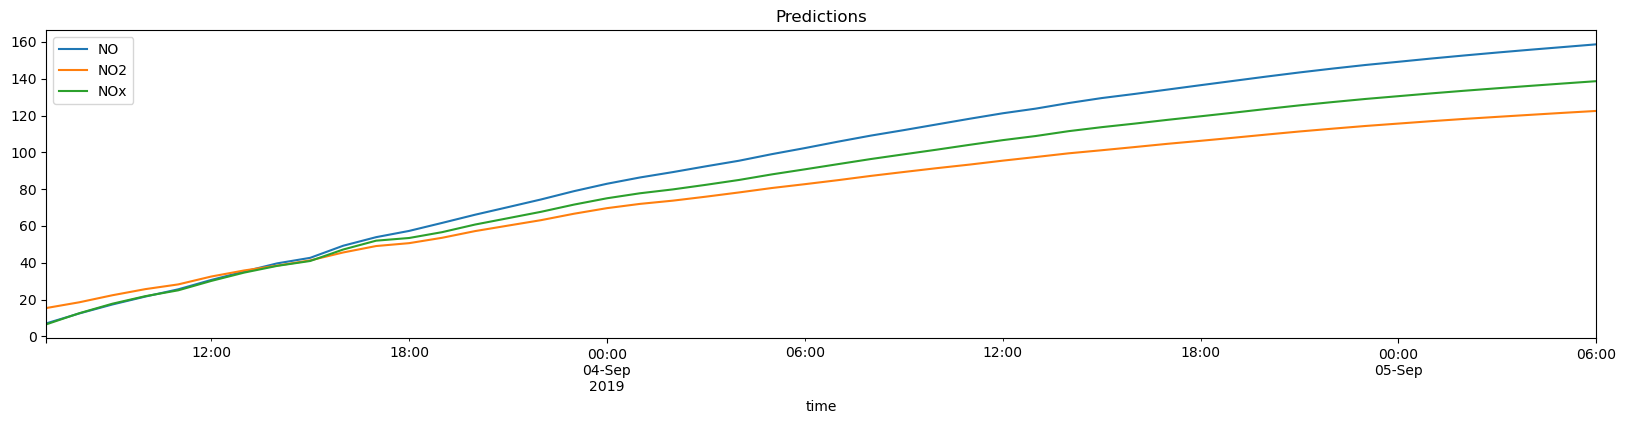

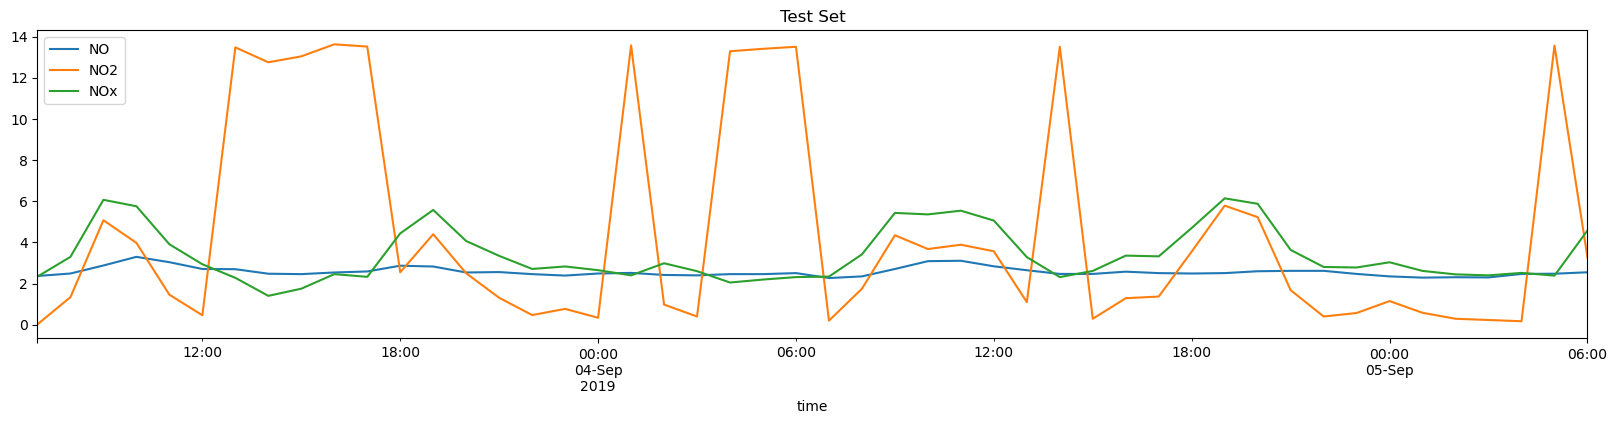

In [30]:
step = 48
dateTimeIndex = pd.date_range(dataFrame.index[-1] + pd.DateOffset(hours=1), periods=step, freq="H")
predictions = results.forecast(dataFrame.values[-lag :], steps = step)
dataFramePredicted = pd.DataFrame({'time':dateTimeIndex, 'NO':predictions[:,0], 'NO2':predictions[:,1], 'NOx':predictions[:,2]})
dataFramePredicted = dataFramePredicted.set_index('time')
print(dataFramePredicted)
dataFramePredicted.plot(figsize=(20,4), title='Predictions')
testSet.plot(figsize=(20,4), title='Test Set')


In [31]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})
tmp = []
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,0], testSet.iloc[:,0]))
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,1], testSet.iloc[:,1]))
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,2], testSet.iloc[:,2]))
metric = pd.DataFrame(tmp,index=dataFramePredicted.columns.values)
print(metric)

           mape         me        mae         mpe        rmse      corr  \
NO    37.359402  94.328098  94.328098   37.359402  104.717427 -0.330621   
NO2  113.386785  74.249992  74.249992  113.386785   81.360166 -0.192548   
NOx   27.372414  82.832366  82.832366   27.372414   91.374344  0.022894   

       minmax  
NO   0.953449  
NO2  0.922265  
NOx  0.936116  


C:\Users\Admin\AppData\Local\Temp\ipykernel_13152\3187061451.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None],
C:\Users\Admin\AppData\Local\Temp\ipykernel_13152\3187061451.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_13152\3187061451.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None],
C:\Users\Admin\AppData\Local\Temp\ipykernel_13152\3187061451.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `ob